In [68]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

data = pd.read_excel("https://www.dropbox.com/s/19acuzv2yrwpoun/servicesdataset%202.xlsx?dl=1")
data_original = data.copy()

## Data Cleaning

In [48]:
# Filtering to get countries which trade and have data for GDP, then taking logs
data0 = data[(data['trade'] > 0) & ~(data['gdp_exp'].isnull()) & ~(data['gdp_imp'].isnull()) & ~(data['distw'].isnull())]
data0_b = data0[['exp', 'imp', 'trade', 'distw', 'gdp_exp', 'gdp_imp']]
logdata0 = data0_b.apply(lambda x: np.log(x) if np.issubdtype(x.dtype, np.number)else x)
logdata0_graph = logdata0.copy()
logdata0_graph['combined_gdp'] = logdata0_graph['gdp_exp'] + logdata0_graph['gdp_imp']

In [49]:
logdata0

,exp,imp,trade,distw,gdp_exp,gdp_imp
28,GBR,AGO,5.152221,8.866808,28.161649,23.431316
30,ITA,AGO,2.520591,8.674289,27.726331,23.431316
32,DNK,AGO,3.212943,8.896760,25.859064,23.431316
34,FRA,AGO,4.312351,8.761676,27.967493,23.431316
37,BEL,AGO,2.009766,8.827272,26.244727,23.431316
...,...,...,...,...,...,...
31081,BEL,ZWE,1.316620,9.004719,26.244727,22.446032
31086,NLD,ZWE,2.297448,9.016893,26.739423,22.446032
31087,ITA,ZWE,2.297448,8.864830,27.726331,22.446032
31089,DNK,ZWE,1.603506,9.044623,25.859064,22.446032


## Pre-plots

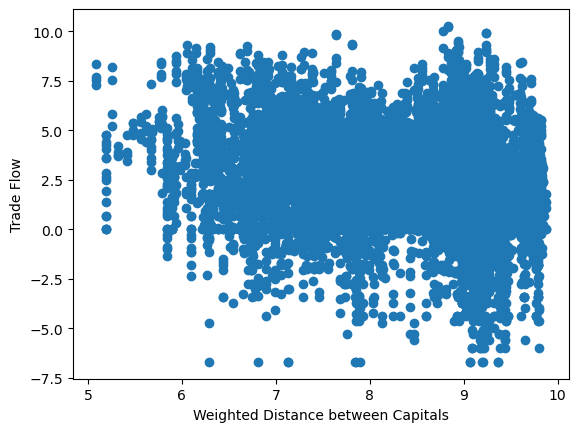

In [50]:
# Visualise 1: Trade flow VS Weighted Distance
plt.scatter(logdata0["distw"], logdata0["trade"])
plt.xlabel("Weighted Distance between Capitals")
plt.ylabel("Trade Flow")
plt.show()

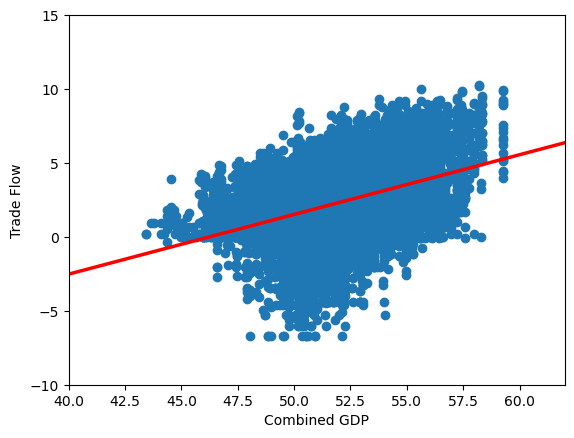

In [69]:
# Visualise 1: Trade flow VS GDP
plt.scatter(logdata0_graph["combined_gdp"], logdata0_graph["trade"])
plt.xlabel("Combined GDP")
plt.ylabel("Trade Flow")
plt.xlim([40, 62])
plt.ylim([-10, 15])
b, a = np.polyfit(logdata0_graph["combined_gdp"], logdata0_graph["trade"], deg=1)
xseq = np.linspace(40, 62, num=100)
plt.plot(xseq, a + b * xseq, color="r", lw=2.5)

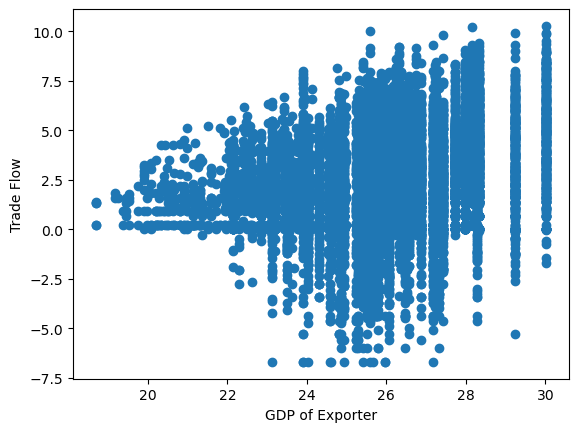

In [70]:
# Visualise 2: Trade flow VS GDP of Exporter
plt.scatter(logdata0["gdp_exp"], logdata0["trade"])
plt.xlabel("GDP of Exporter")
plt.ylabel("Trade Flow")
plt.show()

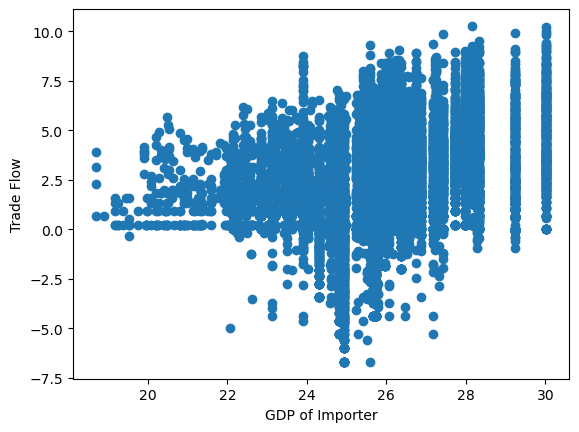

In [73]:
# Visualise 3: Trade flow VS GDP of Importer
plt.scatter(logdata0["gdp_imp"], logdata0["trade"])
plt.xlabel("GDP of Importer")
plt.ylabel("Trade Flow")
plt.show()

## Regression

### 1 | Simple linear regression
$$
\log(trade_{ij}) = \alpha + \beta_1 \log(distw) + \beta_2 \log(GDP_i) +	\beta_3 \log(GDP_j) + ϵ
$$

In [74]:
X_a = logdata0.drop(['trade', 'exp', 'imp'], axis=1)
Y_a = logdata0[['trade']]

# Add a constant to the independent variables
X_a = sm.add_constant(X_a)

# Fit lm model
model_no_fix = sm.OLS(Y_a, X_a).fit()

In [75]:
# Summary statistics
print(model_no_fix.summary())

                            OLS Regression Results                            
Dep. Variable:                  trade   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     1218.
Date:                Sat, 25 Feb 2023   Prob (F-statistic):               0.00
Time:                        10:05:15   Log-Likelihood:                -24612.
No. Observations:               11325   AIC:                         4.923e+04
Df Residuals:                   11321   BIC:                         4.926e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.8283      0.428    -39.294      0.0

### 2 | Add country fixed effects
$$
\log(trade_{ij}) = Σ_{i=1}^N\alpha_i D_{ni} + \beta_1 \log(distw) + \beta_2 \log(GDP_i) +	\beta_3 \log(GDP_j) + ϵ
$$

where $\alpha$ represents the country, and $D$ a dummy indicating if country $n$ is importing to country $i$

In [76]:
dummy_data = pd.get_dummies(data = logdata0, prefix = ['exp', 'imp'], columns= ['exp', 'imp'], drop_first = True)

X_b = dummy_data.drop(['trade'], axis=1)
Y_b = dummy_data[['trade']]

# Add a constant to the independent variables
X_b = sm.add_constant(X_b)

# Fit lm model
model_fix_country = sm.OLS(Y_b, X_b).fit()

In [77]:
# Summary statistics
print(model_fix_country.summary())

                            OLS Regression Results                            
Dep. Variable:                  trade   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     34.38
Date:                Sat, 25 Feb 2023   Prob (F-statistic):               0.00
Time:                        10:05:25   Log-Likelihood:                -22092.
No. Observations:               11325   AIC:                         4.487e+04
Df Residuals:                   10984   BIC:                         4.737e+04
Df Model:                         340                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4553      0.534      0.853      0.3

### 3 | Add sector fixed effects

$$
\log(trade_{ij}) = Σ_{i=1}^N\alpha_i D_{ni} + \beta_1 \log(distw) + \beta_2 \log(GDP_i) +	\beta_3 \log(GDP_j) + ϵ
$$

where $\alpha$ represents the country, and $D$ a dummy indicating if country $n$ is mainly of sector type $i$

In [78]:
data0_sector = data0[['exp', 'imp', 'sector', 'trade', 'distw', 'gdp_exp', 'gdp_imp']]
logdata0_sector = data0_sector.apply(lambda x: np.log(x) if np.issubdtype(x.dtype, np.number)else x)
dummy_data_sector = pd.get_dummies(data = logdata0_sector, prefix = ['exp', 'imp', 'sector'], columns= ['exp', 'imp','sector'], drop_first = True)
dummy_data_sector

,trade,distw,gdp_exp,gdp_imp,exp_ALB,exp_ARE,exp_ARG,exp_ARM,exp_ATG,exp_AUS,...,imp_ZWE,sector_CNS,sector_COM,sector_FIN,sector_INS,sector_PUB,sector_ROS,sector_SER,sector_TRD,sector_TSP
28,5.152221,8.866808,28.161649,23.431316,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
30,2.520591,8.674289,27.726331,23.431316,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32,3.212943,8.896760,25.859064,23.431316,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
34,4.312351,8.761676,27.967493,23.431316,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
37,2.009766,8.827272,26.244727,23.431316,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31081,1.316620,9.004719,26.244727,22.446032,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
31086,2.297448,9.016893,26.739423,22.446032,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
31087,2.297448,8.864830,27.726331,22.446032,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
31089,1.603506,9.044623,25.859064,22.446032,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [79]:
X_sector = dummy_data_sector.drop(['trade'], axis=1)
Y_sector = dummy_data_sector[['trade']]
X_sector = sm.add_constant(X_sector)
model_fix_sector = sm.OLS(Y_sector, X_sector).fit()
print(model_fix_sector.summary())

                            OLS Regression Results                            
Dep. Variable:                  trade   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     81.07
Date:                Sat, 25 Feb 2023   Prob (F-statistic):               0.00
Time:                        10:05:41   Log-Likelihood:                -18977.
No. Observations:               11325   AIC:                         3.865e+04
Df Residuals:                   10975   BIC:                         4.122e+04
Df Model:                         349                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.9093      0.419    -11.710      0.0

### 4 | Using a ln(x+1) transformation to include the trade data with value of zero

In [80]:
# Filtering for GDP and distance data which is available, and taking logs
data = data[~(data['gdp_exp'].isnull()) & ~(data['gdp_imp'].isnull()) & ~(data['distw'].isnull())]
data = data[['exp', 'imp', 'trade', 'distw', 'gdp_exp', 'gdp_imp']]
logdata = data.apply(lambda x: np.log(x+1) if np.issubdtype(x.dtype, np.number)else x)
logdata_graph = logdata.copy()
logdata_graph['combined_gdp'] = logdata_graph['gdp_exp'] + logdata_graph['gdp_imp']

In [81]:
# Adding dummy variables for countries to take fixed effects
dummy_data = pd.get_dummies(data = logdata, prefix = ['exp', 'imp'], columns= ['exp', 'imp'], drop_first = True)
X = dummy_data.drop(['trade'], axis=1)
Y = dummy_data[['trade']]
X = sm.add_constant(X)
OLS = sm.OLS(Y, X).fit()
OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  trade   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     33.94
Date:                Sat, 25 Feb 2023   Prob (F-statistic):               0.00
Time:                        10:05:57   Log-Likelihood:                -52731.
No. Observations:               28789   AIC:                         1.062e+05
Df Residuals:                   28441   BIC:                         1.090e+05
Df Model:                         347                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1101      0.257     -0.428      0.669      -0.614       0.394
distw         -0.3709      0.018    -21.153      0.000      -0.405      -0.337
gdp_exp        0.1521      0.012     12.267      0.000       0.128       0.176
gdp_imp        0.1300      0.012     10.490      0.000       0.106       0.154
exp_ALB       -2.4113      0.399     -6.041      0.000      -3.194      -1.629
exp_ARE        0.6043      0.519      1.165      0.244      -0.412       1.621
exp_ARG       -1.7858      0.431     -4.140      0.000      -2.631      -0.940
exp_ARM       -1.3985      0.555     -2.519      0.012      -2.487      -0.310
exp_ATG       -1.3410      0.570     -2.354      0.019      -2.457      -0.225
exp_AUS       -1.1137      0.432     -2.576      0.010      -1.961      -0.266
exp_AUT       -2.0048      0.423     -4.741      0.000      -2.834      -1.176
exp_AZE       -0.7777      0.574     -1.356      0.175      -1.902       0.346
exp_BDI       -1.7289      0.556     -3.108      0.002      -2.819      -0.639
exp_BEL       -1.7998      0.425     -4.237      0.000      -2.632      -0.967
exp_BEN       -1.6858      0.565     -2.985      0.003      -2.793      -0.579
exp_BFA       -1.2435      0.567     -2.195      0.028      -2.354      -0.133
exp_BGD       -0.3351      0.564     -0.594      0.553      -1.441       0.771
exp_BGR       -1.8622      0.406     -4.592      0.000      -2.657      -1.067
exp_BHR        0.2186      0.563      0.388      0.698      -0.885       1.322
exp_BHS        0.5633      0.549      1.027      0.305      -0.512       1.639
exp_BIH       -0.9195      0.542     -1.697      0.090      -1.981       0.142
exp_BLR       -2.5289      0.411     -6.153      0.000      -3.335      -1.723
exp_BLZ       -0.9821      0.547     -1.794      0.073      -2.055       0.091
exp_BOL       -1.1439      0.553     -2.070      0.038      -2.227      -0.061
exp_BRA       -1.6117      0.439     -3.671      0.000      -2.472      -0.751
exp_BRN       -1.3544      0.514     -2.637      0.008      -2.361      -0.348
exp_BTN       -1.6953      0.555     -3.057      0.002      -2.782      -0.608
exp_BWA       -1.3318      0.561     -2.375      0.018      -2.431      -0.233
exp_CAF       -1.4599      0.557     -2.620      0.009      -2.552      -0.368
exp_CAN       -1.1623      0.439     -2.648      0.008      -2.023      -0.302
exp_CHE       -0.4341      0.431     -1.008      0.313      -1.278       0.410
exp_CHL       -1.6346      0.420     -3.891      0.000      -2.458      -0.811
exp_CHN       -1.2663      0.448     -2.830      0.005      -2.143      -0.389
exp_CMR       -0.8208      0.563     -1.457      0.145      -1.925       0.284
exp_COG       -0.6883      0.556     -1.238      0.216      -1.778       0.401
exp_COL       -2.0146      0.425     -4.742      0.000      -2.847      -1.182
ex

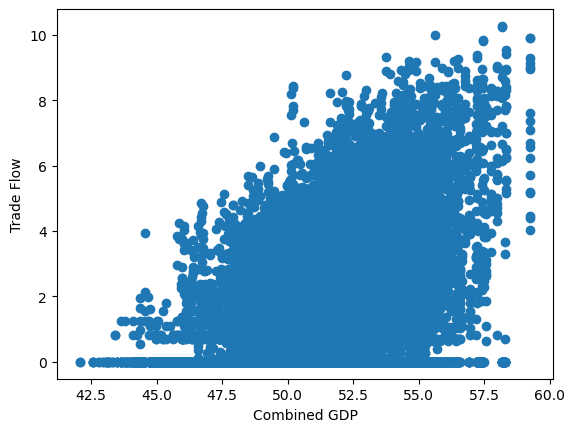

In [82]:
# Visualisation: Trade flow VS GDP 
plt.scatter(logdata_graph["combined_gdp"], logdata_graph["trade"])
plt.xlabel("Combined GDP")
plt.ylabel("Trade Flow")
plt.show()

## Evaluate results

### Check if GM assumptions hold
1. Linearity: the parameters we are estimating using the OLS method must be themselves linear.
2. Random: our data must have been randomly sampled from the population.
3. Non-Collinearity: the regressors being calculated aren’t perfectly correlated with each other.
4. Exogeneity: the regressors aren’t correlated with the error term.
5. Homoscedasticity: no matter what the values of our regressors might be, the error of the variance is constant.

In [83]:
# Testing area
model_fix_sector.rsquared_adj

0.7116333941874046

In [84]:
def r_sq(model):
    return f"Adjusted R-squared: {model.rsquared_adj}"

def test_assumptions(model, X):
    residuals = model.resid

    # NORMALITY OF THE RESIDUALS -----------------------------------------------
    # Shapiro-Wilk test
    stat, p = stats.shapiro(residuals)
    print("Shapiro-Wilk test statistic:", stat)
    print("p-value:", p)
    # Q-Q plot
    sm.qqplot(residuals, line="s")
    plt.title("Normality?")
    plt.show()
    print()

    # HOMOSKEDASTICITY OF THE RESIDUALS ----------------------------------------
    # Breusch-Pagan test
    bp_test = sm.stats.diagnostic.het_breuschpagan(residuals, X)
    print("Breusch-Pagan test statistic:", bp_test[0])
    print("p-value:", bp_test[1])
    # scatter plot of the residuals vs. the predicted values
    plt.scatter(model.predict(X), residuals)
    plt.axhline(y=0, color="r", linestyle="-")
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.title("Homoskedasticity? Residuals vs. Predicted values")
    plt.show()
    print()

    # LINEARITY of the relationship --------------------------------------------
    # Scatter plot of the residuals vs. the predicted values
    plt.scatter(model.predict(X), residuals)
    plt.axhline(y=0, color="r", linestyle="-")
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.title("Linearity? Residuals vs. the Predicted values")
    plt.show()
    print()

Model: model_no_fix -------------------------------------- 

Adjusted R-squared: 0.24377002559083016

Shapiro-Wilk test statistic: 0.9932098984718323
p-value: 9.809687304815018e-23


/Users/kathrynhackney/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


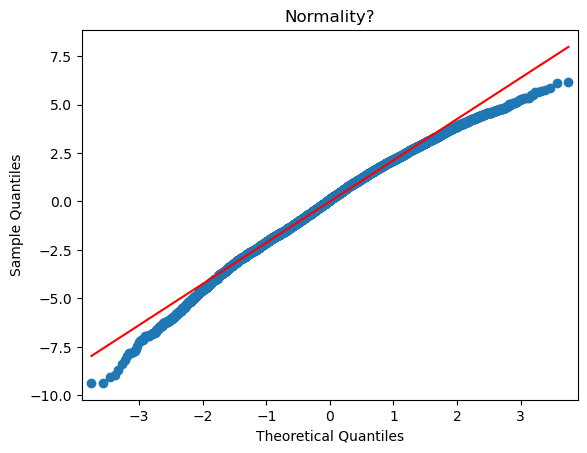


Breusch-Pagan test statistic: 82.7822573772592
p-value: 7.764691732206177e-18


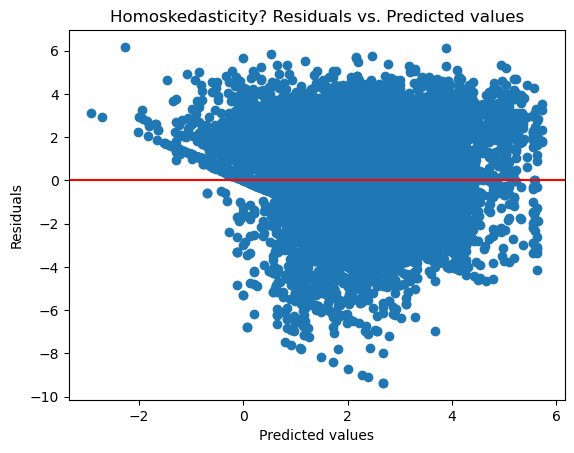

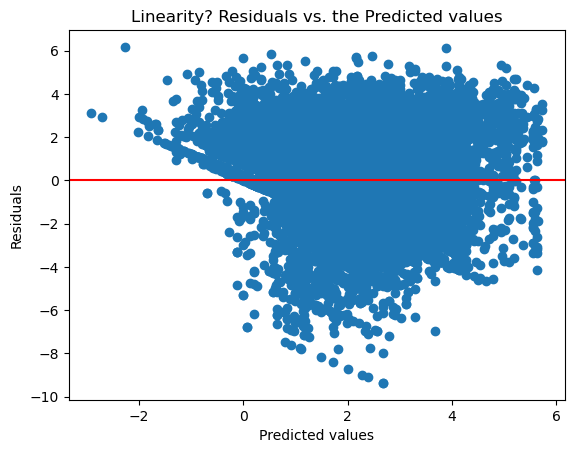


---------------------------------------------------------------
Model: model_fix_country -------------------------------------- 

Adjusted R-squared: 0.50052988479265

Shapiro-Wilk test statistic: 0.9981141686439514
p-value: 1.4610386511737516e-10


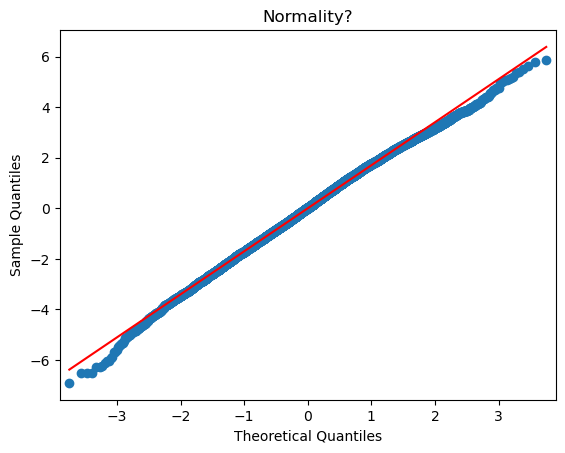


Breusch-Pagan test statistic: 1409.2561768571823
p-value: 2.4886874330001483e-129


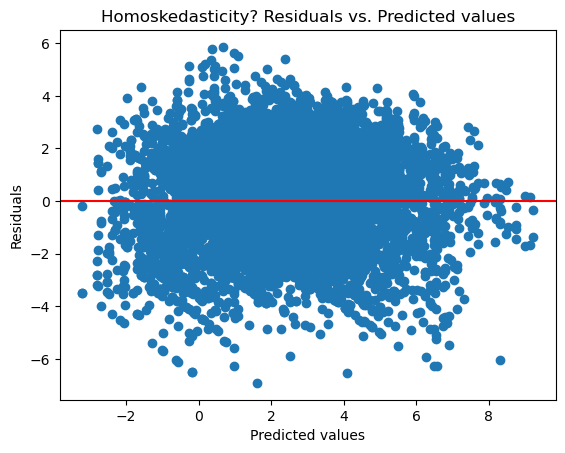

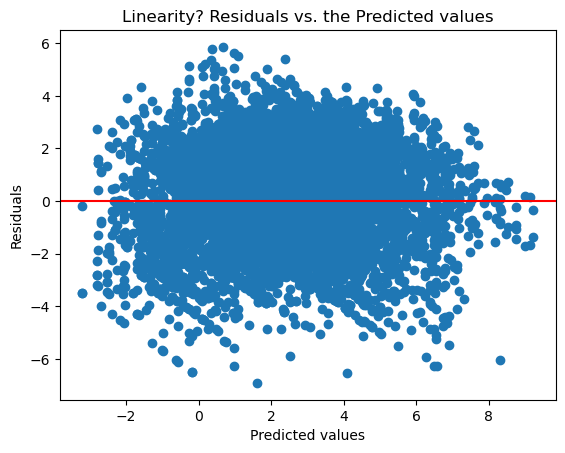


---------------------------------------------------------------
Model: model_fix_sector -------------------------------------- 

Adjusted R-squared: 0.7116333941874046

Shapiro-Wilk test statistic: 0.9936108589172363
p-value: 4.8403914445315455e-22


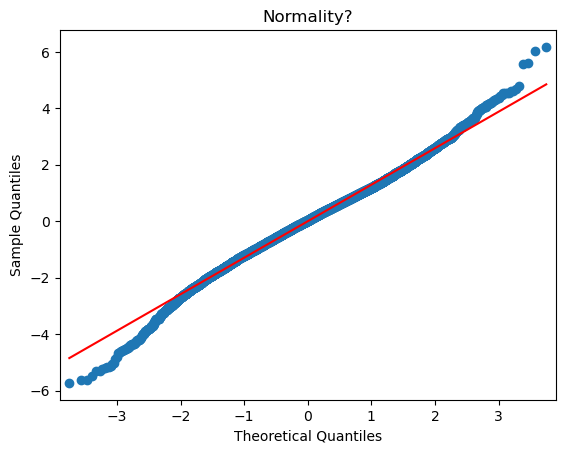


Breusch-Pagan test statistic: 1224.3601196926354
p-value: 4.5731312740648064e-97


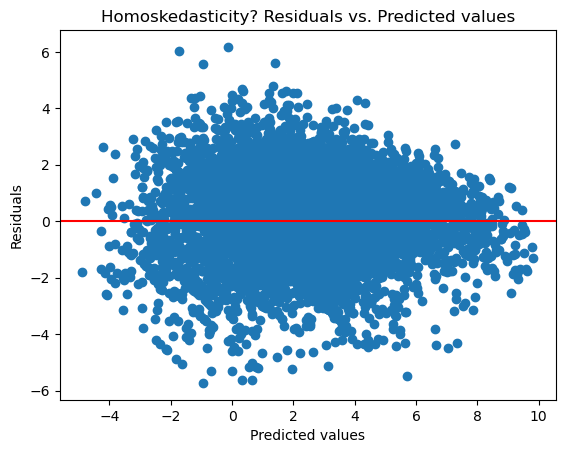

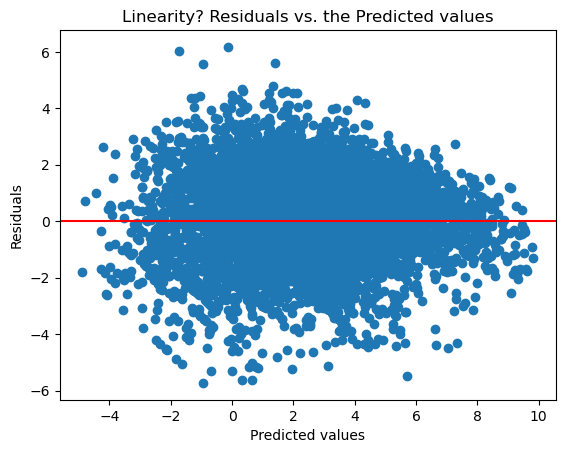


---------------------------------------------------------------


In [85]:
models = [model_no_fix, model_fix_country, model_fix_sector]
model_names = ['model_no_fix', 'model_fix_country', 'model_fix_sector']
X = [X_a, X_b, X_sector]

for i, model in enumerate(models):
    print(f'Model: {model_names[i]} -------------------------------------- \n')
    print(r_sq(model))
    print()
    test_assumptions(model, X[i])
    print('---------------------------------------------------------------')

## Visualising results 

In [66]:
import seaborn as sns

### Heatmap

In [67]:
#Create pivot table
table = data.pivot(index='country_i', columns='country_j', values='trade')

#Create heatmap
sns.heatmap(table, cmap='YlGnBu', square=True)

KeyError: 'country_i'

### Network graph / map

In [ ]:
import networkx as nx

In [ ]:
# Create graph
G = nx.from_pandas_edgelist(data, source='country_i', target='country_j', edge_attr='trade')

# Set node attributes
for node in G.nodes:
    G.nodes[node]['GDP_exp'] = data.loc[data['country_i'] == node, 'GDP_exp'].iloc[0]

# Create layout
pos = nx.spring_layout(G)

# Draw graph
nx.draw_networkx_nodes(G, pos, node_size=GDP, node_color='red')
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos)
plt.axis('off')
plt.show()

In [86]:
!pip install geopandas
import geopandas as gpd

In [87]:
# Read the Shapefile using geopandas
gdf = gpd.read_file("/vsicurl/https://github.com/nvkelso/natural-earth-vector/raw/master/50m_cultural/ne_50m_admin_0_countries.shp")

In [88]:
# Unique country list
country_list = data['exp'].unique().tolist()
print(country_list)

['GBR', 'FIN', 'ITA', 'CZE', 'DNK', 'LUX', 'FRA', 'HUN', 'AUT', 'BEL', 'HKG', 'IRL', 'PRT', 'NLD', 'SVN', 'MLT', 'CYP', 'HRV', 'ROM', 'LTU', 'RUS', 'LVA', 'SVK', 'TUR', 'JPN', 'EST', 'ESP', 'POL', 'USA', 'SWE', 'DEU', 'GRC', 'CAN', 'NZL', 'IND', 'NOR', 'PER', 'MYS', 'BRN', 'PHL', 'ZAF', 'KOR', 'THA', 'CHN', 'CHE', 'FJI', 'CHL', 'PNG', 'IDN', 'VNM', 'SGP', 'MEX', 'ISL', 'BLR', 'ALB', 'MAR', 'KHM', 'IRN', 'AUS', 'BHR', 'ETH', 'COL', 'BGD', 'ARE', 'NGA', 'BGR', 'PAN', 'VEN', 'TTO', 'SLB', 'UZB', 'ARG', 'GRD', 'BDI', 'QAT', 'TCD', 'KNA', 'SDN', 'EGY', 'UKR', 'BFA', 'RWA', 'BRA', 'MUS', 'NAM', 'SYR', 'GAB', 'YEM', 'BHS', 'PRY', 'SAU', 'ISR', 'SLV', 'WSM', 'GRL', 'MKD', 'DZA', 'LSO', 'LBR', 'CRI', 'KAZ', 'URY', 'BIH', 'OMN', 'BTN', 'KGZ', 'SYC', 'HND', 'TJK', 'CMR', 'BEN', 'DJI', 'MWI', 'ERI', 'MDA', 'VUT', 'NIC', 'SMR', 'AZE', 'MNG', 'KIR', 'TON', 'AGO', 'TUN', 'LBN', 'LAO', 'COM', 'KEN', 'GHA', 'SWZ', 'PAK', 'KWT', 'GEO', 'GTM', 'MRT', 'JAM', 'SUR', 'ARM', 'SLE', 'GNQ', 'UGA', 'GUY', 'BOL'

## Export map

In [89]:
# Getting total exports for each country
exp_dict = {}

for c in country_list:
    exp_dict[c] = data.loc[data['exp'] == c, 'trade'].sum()

agg_export = pd.DataFrame(list(exp_dict.items()), columns=['Country', 'Export'])
agg_export.head()

,Country,Export
0,GBR,179568.674388
1,FIN,14685.315955
2,ITA,65506.546079
3,CZE,6495.700450
4,DNK,32259.584152


In [90]:
agg_export.sort_values(by=['Export'], ascending = False)

,Country,Export
28,USA,316438.182848
0,GBR,179568.674388
30,DEU,151984.178052
24,JPN,115667.983868
6,FRA,98136.866999
...,...,...
120,KIR,0.000000
170,FSM,0.000000
121,TON,0.000000
156,PLW,0.000000


In [91]:
# Merging export data with gdf
merged_exp = gdf.set_index("ADM0_A3").join(agg_export.set_index("Country"))
merged_exp.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry,Export
ADM0_A3,,,,,,,,,,,,,,,,,,,,,
ZWE,Admin-0 country,1,3,Zimbabwe,ZWE,0,2,Sovereign country,1,Zimbabwe,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344...",184.040913
ZMB,Admin-0 country,1,3,Zambia,ZMB,0,2,Sovereign country,1,Zambia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643...",93.994048
YEM,Admin-0 country,1,3,Yemen,YEM,0,2,Sovereign country,1,Yemen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16...",160.916099
VNM,Admin-0 country,3,2,Vietnam,VNM,0,2,Sovereign country,1,Vietnam,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((104.06396 10.39082, 104.08301 ...",801.978688
VEN,Admin-0 country,5,3,Venezuela,VEN,0,2,Sovereign country,1,Venezuela,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9...",3127.502416


<AxesSubplot:>

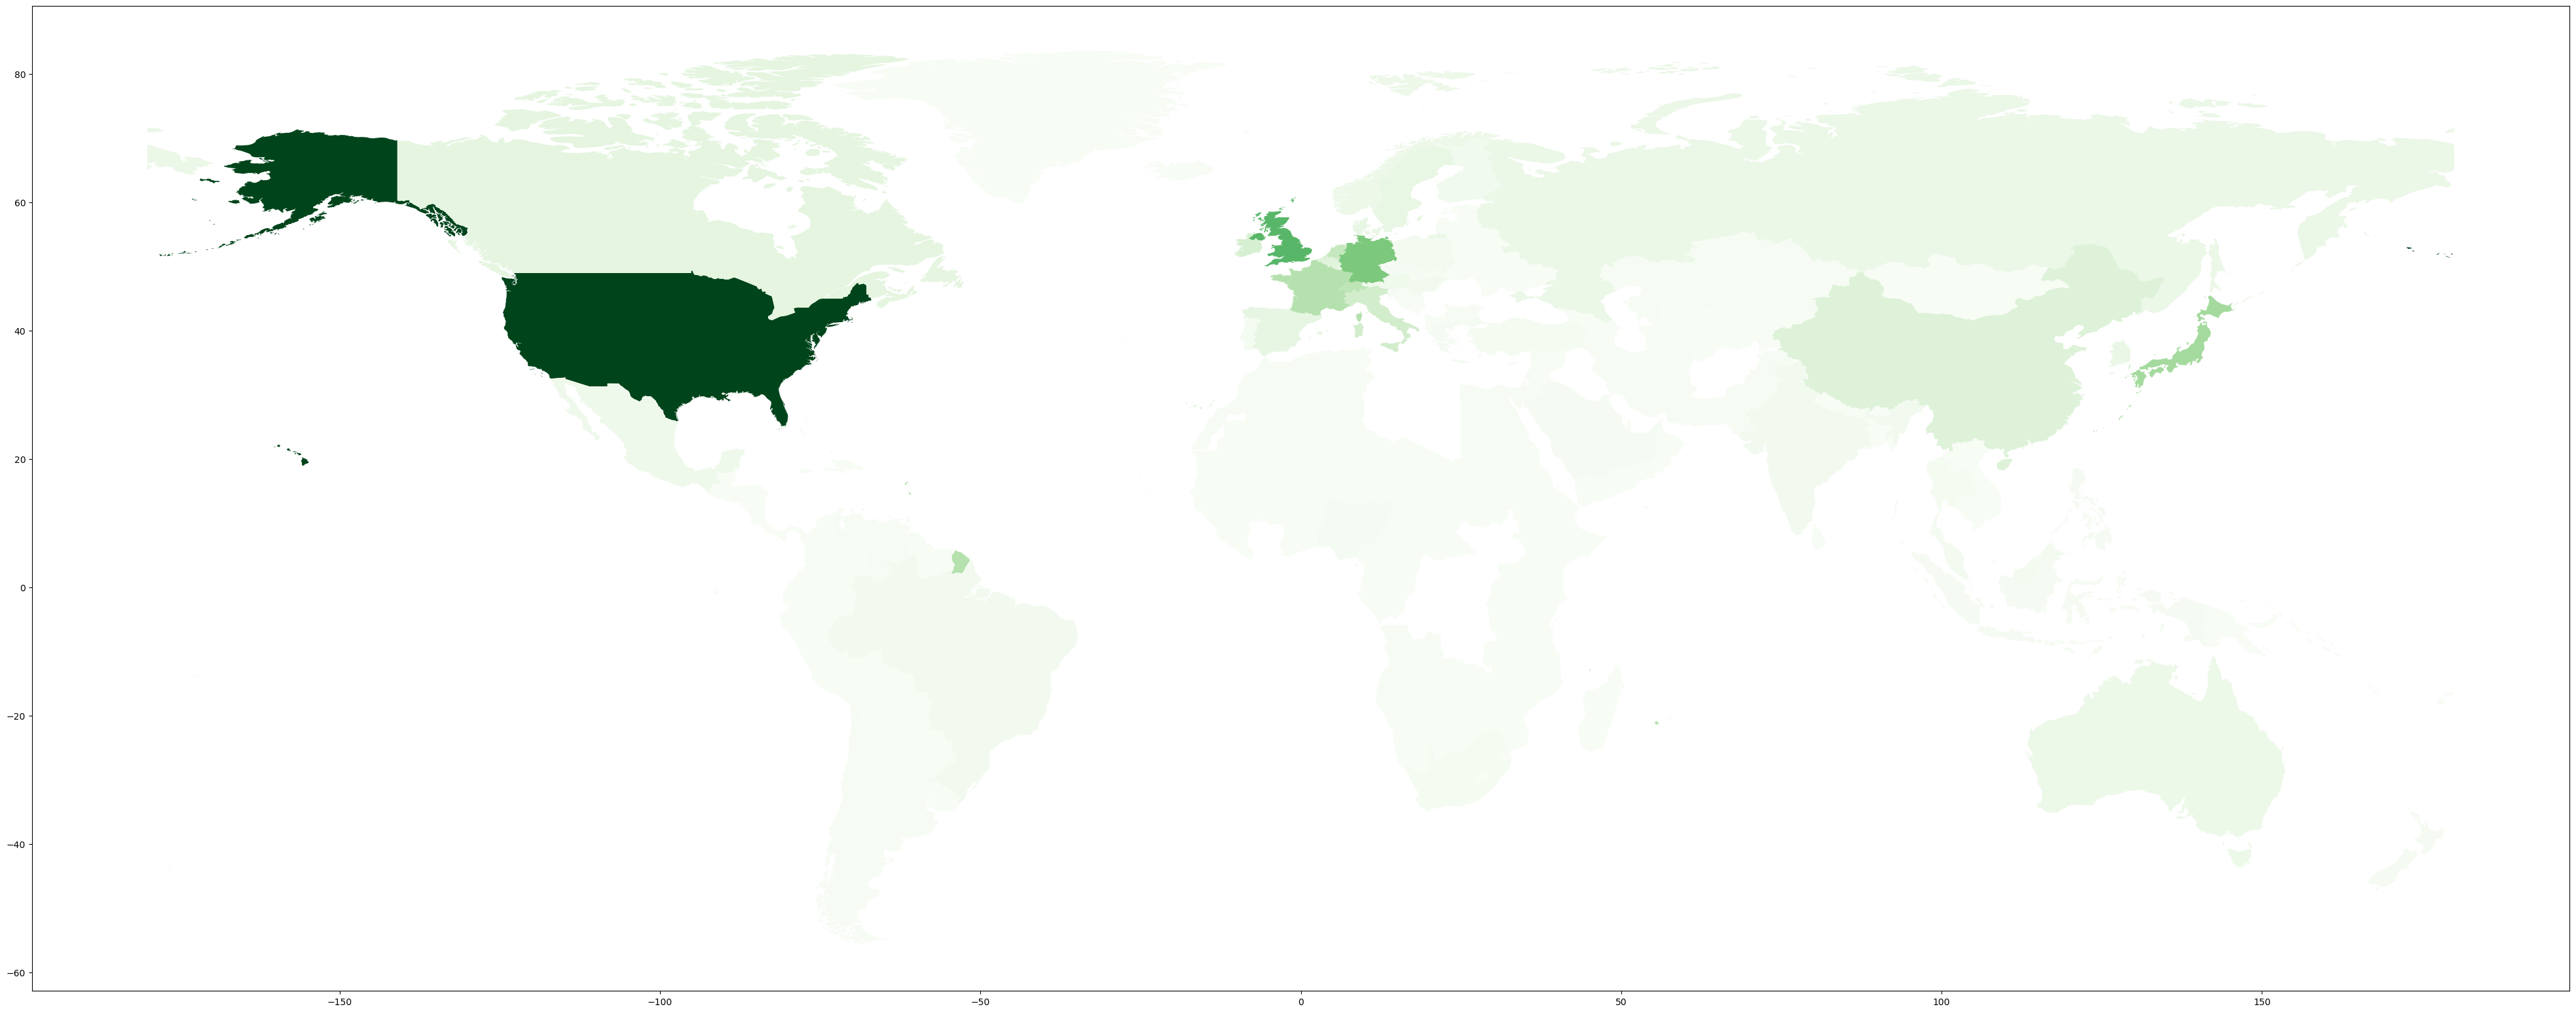

In [92]:
# Plot the export map
fig, ax = plt.subplots(figsize=(50, 40))
merged_exp.plot(column = 'Export', cmap = 'Greens', linewidth = 0.8, ax=ax)
# Adding country names
for i,geo in merged_exp.centroid.items():
    ax.annotate(text=i,xy=[geo.x,geo.y],horizontalalignment="center",color="black")
    ax.axis('off')
    ax.set_title('World Exports by country',fontdict={'fontsize':'25','fontweight':'3'})
plt.show()

## Import map

In [ ]:
# Getting total imports for each country
imp_dict = {}

for c in country_list:
    imp_dict[c] = data.loc[data['imp'] == c, 'trade'].sum()

agg_import = pd.DataFrame(list(imp_dict.items()), columns=['Country', 'Import'])
agg_import.head()

In [ ]:
# Merging import data with gdf
merged_imp = gdf.set_index("ADM0_A3").join(agg_import.set_index("Country"))
merged_imp.head()

In [ ]:
# Plot the import map
fig, ax = plt.subplots(figsize=(50, 40))
merged_imp.plot(column = 'Import',cmap = 'Blues', linewidth = 0.8, ax=ax)
# Adding country names
for i,geo in merged_imp.centroid.items():
    ax.annotate(text=i,xy=[geo.x,geo.y],horizontalalignment="center",color="black")
    ax.axis('off')
    ax.set_title('World Imports by country',fontdict={'fontsize':'25','fontweight':'3'})
plt.show()

## Combined trade map

In [ ]:
# Getting combined trade for each country
agg_trade = agg_export.set_index('Country').join(agg_import.set_index('Country'))
agg_trade['Combined'] = agg_trade['Export'] + agg_trade['Import']
agg_trade = agg_trade.drop('Export', axis=1)
agg_trade = agg_trade.drop('Import', axis=1)
agg_trade.head()

In [ ]:
# Merging combined trade data with gdf
merged_comb = gdf.set_index("ADM0_A3").join(agg_trade)
merged_comb.head()

In [ ]:
# Plot the combined trade map
fig, ax = plt.subplots(figsize=(50, 40))
merged_comb.plot(column = 'Combined', cmap = 'Reds', linewidth = 0.8, ax=ax)
# Adding country names
for i,geo in merged_comb.centroid.items():
    ax.annotate(text=i,xy=[geo.x,geo.y],horizontalalignment="center",color="black")
    ax.axis('off')
    ax.set_title('World Trade by country',fontdict={'fontsize':'25','fontweight':'3'})
plt.show()

## EU map

In [ ]:
# Creating EU dataframes
EU = ['AUT','BEL','CYP','CZE','DNK','EST','FIN','FRA','DEU','GRC','HUN','IRL','ITA','LVA','LTU','LUX','MLT','NLD','POL','PLT','SVK','SVN','ESP','SWE','GBR']

europe_exp_merged = merged_exp.query("ADM0_A3 in @EU")
europe_imp_merged = merged_imp.query("ADM0_A3 in @EU")
europe_tot_merged = merged_tot.query("ADM0_A3 in @EU")

In [ ]:
# Plot the European export map
fig, ax = plt.subplots(figsize=(30, 20))
europe_exp_merged.plot(column = 'Export',cmap = 'Greens', linewidth = 0.8, ax=ax)
# Adding country names
for i,geo in europe_exp_merged.centroid.items():
    ax.annotate(text=i,xy=[geo.x,geo.y],horizontalalignment="center",color="black")
    ax.axis('off')
    ax.set_title('EU export by country',fontdict={'fontsize':'25','fontweight':'3'})
plt.show()